In [2]:
import pandas as pd
import yfinance as yf  # Yahoo Finance API for fetching stock data
import matplotlib.pyplot as plt
import numpy as np

from ta.utils import dropna

from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import BollingerBands

import warnings
warnings.simplefilter('ignore')

C:\Users\kaygo\AppData\Local\Temp\ipykernel_4520\2025506116.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [27]:
# Define MAANG stocks and time period
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2014-12-01'
end_date = '2019-12-31'

columns_to_drop = ['Dividends', 'Stock Splits']
result_df = pd.DataFrame()

for each_stock in tickers:
    stock_data = yf.Ticker(each_stock)
    hist_stock_data = stock_data.history(start = start_date, end = end_date)
    hist_stock_data_copy = hist_stock_data.copy()
    hist_stock_data_copy = hist_stock_data_copy.drop(columns_to_drop, axis=1)
    hist_stock_data_copy.columns = [each_stock + '_' + col for col in hist_stock_data_copy.columns]
    result_df = pd.concat([result_df, hist_stock_data_copy], axis=1)

In [28]:
result_df.head()

,META_Open,META_High,META_Low,META_Close,META_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,...,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01 00:00:00-05:00,77.178115,77.228058,74.720724,75.020401,31789900,26.554041,26.652381,24.868850,25.718151,335256000,...,49.285713,49.571430,48.234287,48.830002,11964400,27.254499,27.439501,26.931000,26.982500,39888000
2014-12-02 00:00:00-05:00,75.250161,75.829548,74.960467,75.380020,16773900,25.367265,25.870140,25.199640,25.619820,237395600,...,48.757141,50.477142,48.691429,50.330002,14271600,26.972500,27.092501,26.733000,26.929501,41480000
2014-12-03 00:00:00-05:00,75.300106,75.649742,74.321149,74.800636,16689900,25.870142,26.004241,25.727102,25.910372,172253600,...,50.221428,50.731430,49.181431,50.731430,13819400,26.875000,27.070499,26.760500,26.848499,32476000
2014-12-04 00:00:00-05:00,74.750694,75.469932,74.580876,75.160255,14362800,25.874607,26.194212,25.767328,25.812027,168178000,...,50.428570,51.135715,49.908569,50.085712,11853800,26.882000,27.134501,26.744499,27.129000,32598000
2014-12-05 00:00:00-05:00,75.719664,76.678646,75.280128,76.279068,24306400,25.923781,25.943897,25.622056,25.702517,153275600,...,50.147144,50.642857,49.732857,50.131428,9930200,26.834999,26.910000,26.363001,26.403999,61402000


In [29]:
#calculate EMA cross over indicator
def calculate_EMA(df, window_size_S, window_size_L ):
    
    for each_stock in tickers:
        
        stock_close_column = each_stock + '_Close'
        stock_STEMA = each_stock + '_EMA_ST'
        stock_LTEMA = each_stock + '_EMA_LT'
        stock_EMA_Buy_Sell_decision = each_stock + '_EMA_B/S_Decision'

        df[stock_STEMA] = EMAIndicator(close=df[stock_close_column], window=window_size_S).ema_indicator()
        df[stock_LTEMA] = EMAIndicator(close=df[stock_close_column], window=window_size_L).ema_indicator()
        
        conditions = [
            (df[stock_STEMA] > df[stock_LTEMA]),
            (df[stock_STEMA] < df[stock_LTEMA]),
        ]
        choices = ['Buy','Sell']
        df[stock_EMA_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
        
    return df

In [30]:
#calculate RSI indicator
def calculate_RSI(df):
    
    for each_stock in tickers:
        
        stock_close_column = each_stock + '_Close'
        stock_RSI = each_stock + '_RSI'
        stock_RSI_Buy_Sell_decision = each_stock + '_RSI_B/S_Decision'

        df[stock_RSI] = RSIIndicator(close=df[stock_close_column]).rsi()
        
        conditions = [
            (df[stock_RSI] >= 30) & (df[stock_RSI] <= 70),
            (df[stock_RSI] < 30) | (df[stock_RSI] > 70),
        ]
        choices = ['Buy','Sell']
        df[stock_RSI_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
        
    return df

In [31]:
#calculate ADX indicator
def calculate_ADX(df,window_size_S):
    
    for each_stock in tickers:
        
        stock_close_column = each_stock + '_Close'
        stock_high_column = each_stock + '_High'
        stock_low_column = each_stock + '_Low'
        stock_ADX = each_stock + '_ADX'

        df[stock_ADX] = ADXIndicator(high=df[stock_high_column], low=df[stock_low_column], close=df[stock_close_column], window=window_size_S, fillna=True).adx()
        
    return df

In [32]:
#calculate MACD
def calculate_MACD(df):
    for each_stock in tickers:
        
        stock_close_column = each_stock + '_Close'
        stock_MACD = each_stock + '_MACD'
        stock_signal_MACD = each_stock + '_signal_MACD'
        stock_signal_MACD_diff = each_stock + '_signal_MACD_diff'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        stock_ADX = each_stock + '_ADX'
        
        Short_EMA = df[stock_close_column].ewm(span=7, adjust=False).mean() # default MACD period
        Long_EMA = df[stock_close_column].ewm(span=21, adjust=False).mean() # default MACD period
        MACD = Short_EMA - Long_EMA
        signal = MACD.ewm(span=4, adjust=False).mean() # default MACD period
        
        df[stock_MACD] = MACD
        df[stock_signal_MACD] = signal
        df[stock_signal_MACD_diff] = df[stock_MACD] - df[stock_signal_MACD]
        
        conditions = [
            (df[stock_signal_MACD_diff] > 0) & (df[stock_signal_MACD_diff].shift(1) < 0) & (df[stock_ADX] > 25), 
            (df[stock_signal_MACD_diff] < 0) & (df[stock_signal_MACD_diff].shift(1) > 0) & (df[stock_ADX] > 25)
        ]
        choices = ['Buy','Sell']
        df[stock_MACD_Buy_Sell_decision] = np.select(conditions, choices, default='NA')   
    return df

In [33]:
#finalise Buy/Sell
def final_buy_sell(df):
    for each_stock in tickers:
        stock_EMA_Buy_Sell_decision = each_stock + '_EMA_B/S_Decision'
        stock_RSI_Buy_Sell_decision = each_stock + '_RSI_B/S_Decision'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        stock_Final_Decision = each_stock + '_Final_Decision'
        
        conditions = [
            (df[stock_EMA_Buy_Sell_decision] == "Buy") & (df[stock_RSI_Buy_Sell_decision] == "Buy") & (df[stock_MACD_Buy_Sell_decision] == "Buy"), 
            (df[stock_EMA_Buy_Sell_decision] == "Sell") & (df[stock_RSI_Buy_Sell_decision] == "Sell") & (df[stock_MACD_Buy_Sell_decision] == "Sell")
        ]
        choices = ['Buy','Sell']
        df[stock_Final_Decision] = np.select(conditions, choices, default='NA')
    return df

In [34]:
result_df = calculate_EMA(result_df, 5, 21)
result_df = calculate_RSI(result_df)
result_df = calculate_ADX(result_df,5)
result_df = calculate_MACD(result_df)
result_df = final_buy_sell(result_df)

In [35]:
#filepath = '/Users/charleslim/Library/Mobile Documents/com~apple~CloudDocs/NUS MSc Digital FinTech/FT5010 Algorithmic Trading Systems Design and Deployment/Project'
#result_df.to_csv(filepath + '/second_strategy.csv', index=True)

In [36]:
for each_stock in tickers:
    stock_Final_Decision = each_stock + '_Final_Decision'
    print(each_stock)
    print(result_df[stock_Final_Decision].value_counts())

META
META_Final_Decision
NA     1243
Buy      36
Name: count, dtype: int64
AAPL
AAPL_Final_Decision
NA      1252
Buy       26
Sell       1
Name: count, dtype: int64
AMZN
AMZN_Final_Decision
NA     1249
Buy      30
Name: count, dtype: int64
NFLX
NFLX_Final_Decision
NA     1248
Buy      31
Name: count, dtype: int64
GOOGL
GOOGL_Final_Decision
NA     1243
Buy      36
Name: count, dtype: int64


In [37]:
def execute_buy_sell(df):
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df['Cash Balance'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    #df.loc['2015-01-02', 'Cash balance'] = 1000000
    
    #Add columns for shares owned & initial allocation
    for stock in tickers:
        df[stock + '_owned_shares'] = 0 
        if stock + '_Open' in df.columns:  
            initial_price = df.loc['2015-01-02', stock + '_Open']
            #print(initial_price)
            df.loc['2015-01-02', stock + '_owned_shares'] = round(200000 / initial_price)

    start_index = df.index.get_loc(initial_date) + 1
    
    # Iterate over the DataFrame for next day execution based on the previous day's decisions
    for i in range(start_index, len(df.index)):
        current_date = df.index[i]
        previous_date = df.index[i - 1]

        # Initialize daily cash balance based on the previous day's ending balance
        daily_cash_balance = df.at[previous_date, 'Cash Balance']

        buy_stocks = []
        sell_stocks = []

        for stock in tickers:
            decision_column = stock + '_Final_Decision'  # Adjust based on actual column names
            if df.at[previous_date, decision_column] == 'Buy':
                #print(current_date, " - Buy - " ,stock)
                buy_stocks.append(stock)
            elif df.at[previous_date, decision_column] == 'Sell':
                #print(current_date, " - Sell - " , stock)
                sell_stocks.append(stock)
        
        # Execute sells first to update the cash balance
        if sell_stocks:
            for stock in sell_stocks:
                print(current_date, " - Sell - " ,stock)
                sell_price = df.at[current_date, stock + '_Open']
                print("Selling price ", sell_price)
                shares_to_sell = df.at[previous_date, stock + '_owned_shares']
                print("Previous date ", previous_date)
                print("Stocks owned on previous date (shares to sell): ", shares_to_sell)
                daily_cash_balance = daily_cash_balance + (sell_price * shares_to_sell) # Increase cash balance
                print("Cash Balance after selling shares: ", daily_cash_balance)
                df.at[current_date, stock + '_owned_shares'] = 0  # Reset shares to 0 after selling
                print("Shares owned on current date after selling: ", df.at[current_date, stock + '_owned_shares'])   
            all_stocks = set(tickers)
            sell_set = set(sell_stocks)
            not_sell = all_stocks - sell_set
            buy_stocks = list(not_sell)
            print("Not sell stocks: ",not_sell)
            print("buy_stocks list after selling shares: ",buy_stocks)
        # Execute buys with the updated cash balance
        if buy_stocks:
            cash_per_stock = daily_cash_balance / len(buy_stocks) if daily_cash_balance > 0 else 0
            for stock in buy_stocks:
                if cash_per_stock > 0:
                    print(current_date, " - Buy - " ,stock)
                    buy_price = df.at[current_date, stock + '_Open']
                    print("Buying price ", buy_price)
                    shares_to_buy = round(cash_per_stock / buy_price)
                    print("Previous date ", previous_date)
                    print("Stocks owned on previous date: ", df.at[previous_date, stock + '_owned_shares'])
                    print("Shares to buy: ", shares_to_buy)
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares'] + shares_to_buy  # Add bought shares
                    print("Shares owned after buying: ", df.at[current_date, stock + '_owned_shares'])
                    daily_cash_balance = daily_cash_balance - (shares_to_buy * buy_price)  # Deduct spent cash
                else:
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']
                    
        all_stocks = set(tickers)
        buy_set = set(buy_stocks)
        sell_set = set(sell_stocks)
        
        no_transaction_stocks = all_stocks - (buy_set.union(sell_set))
        print(current_date, 'No transaction stocks : ' , no_transaction_stocks)
        for stock in no_transaction_stocks:
            df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']

        # Update the cash balance at the end of the day
        df.at[current_date, 'Cash Balance'] = daily_cash_balance
    
    return df

In [38]:
def calculate_portfolio_value(df):
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df['Portfolio Value'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    portfolio_value = 0
    current_date = df.index[start_index]
    #calculating the portfolio value on day 1 - 2015/01/02
    for stock in tickers:
        stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
        portfolio_value = portfolio_value + stock_value
    df.at[current_date, 'Portfolio Value'] = portfolio_value
    
    start_index = df.index.get_loc(initial_date) + 1
    
    # len(df.index)
    for i in range(start_index, len(df.index)): 
        portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
            portfolio_value = portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
        #print(portfolio_value)
        df.at[current_date, 'Portfolio Value'] = portfolio_value
    
    return df

In [39]:
def remove_unnecessary_initial_rows(df):
    df.index = pd.to_datetime(df.index)
    initial_date = pd.Timestamp('2015-01-02')
    df = df.loc[initial_date:]
    return df

In [40]:
result_df = execute_buy_sell(result_df)

2015-01-05 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-06 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-07 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-08 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-09 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-12 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-13 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-14 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-15 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-16 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-20 00:00:00 No transaction stocks :  {'AAPL', 'GOOGL', 'NFLX', 'AMZN', 'META'}
2015-01-21 00:00:00 No transaction stocks :

In [41]:
result_df = calculate_portfolio_value(result_df)

In [42]:
result_df = remove_unnecessary_initial_rows(result_df)
print(len(result_df))

1257


In [43]:
def calculate_no_strategy_portfolio_value(df):
    for stock in tickers:
        stock_initial_owned = stock + 'initial_owned'
        stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
        print("Initial stocks owned: ", stock_initial_owned) 
    
    df.index = pd.to_datetime(df.index)
    df['NS Portfolio Value'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    for i in range(start_index, len(df.index)): 
        ns_portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_initial_owned = stock + 'initial_owned'
            stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
            print("Initial stocks owned: ", stock_initial_owned)
            stock_value = stock_initial_owned * df.at[current_date, stock +'_Close']
            ns_portfolio_value = ns_portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
            #print(portfolio_value)
        print("NS Portfolio Value: ", ns_portfolio_value)
        df.at[current_date, 'NS Portfolio Value'] = ns_portfolio_value
    return df

In [44]:
result_df = calculate_no_strategy_portfolio_value(result_df)

Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
NS Portfolio Value:  995078.0572710037
Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
NS Portfolio Value:  968177.8643980026
Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
NS Portfolio Value:  953023.9509124756
Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
NS Portfolio Value:  958124.9796581268
Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  751

In [45]:
def calculate_SP_500_value(df):
    ticker_symbol = "^GSPC"
    start_date = "2015-01-01"
    end_date = '2019-12-31'
    sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    sp500_data.index = pd.to_datetime(sp500_data.index)
    
    sp500_data.to_csv("SP500.csv")
    
    sp500_units_for_1M = round(1000000/sp500_data.at['2015-01-02', 'Open'])
    print(sp500_units_for_1M)
    
    df.index = df.index.date
    
    df['SP_500'] = sp500_data['Close']
    df['SP_500_Value'] = sp500_units_for_1M * df['SP_500']
    
    return df

In [46]:
calculate_SP_500_value(result_df)

[*********************100%%**********************]  1 of 1 completed

486


,META_Open,META_High,META_Low,META_Close,META_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,...,Cash Balance,META_owned_shares,AAPL_owned_shares,AMZN_owned_shares,NFLX_owned_shares,GOOGL_owned_shares,Portfolio Value,NS Portfolio Value,SP_500,SP_500_Value
2015-01-02,78.496719,78.846346,77.617647,78.366852,18177500,24.895676,24.906852,23.992736,24.435266,212818400,...,0.000000,2548,8034,12797,4069,7510,9.950781e+05,9.950781e+05,2058.199951,1.000285e+06
2015-01-05,77.897356,79.166007,76.778540,77.108192,26452200,24.202828,24.283288,23.559148,23.746887,257142000,...,0.000000,2548,8034,12797,4069,7510,9.681779e+05,9.681779e+05,2020.579956,9.820019e+05
2015-01-06,77.148147,77.507759,75.280127,76.069290,27399300,23.811702,24.010617,23.384816,23.749123,263188400,...,0.000000,2548,8034,12797,4069,7510,9.530240e+05,9.530240e+05,2002.609985,9.732685e+05
2015-01-07,76.678644,77.278007,75.739638,76.069290,22045300,23.959210,24.182711,23.847460,24.082136,160423600,...,0.000000,2548,8034,12797,4069,7510,9.581250e+05,9.581250e+05,2025.900024,9.845874e+05
2015-01-08,76.658661,78.147088,75.999365,78.097137,23961000,24.412922,25.065542,24.294465,25.007431,237458000,...,0.000000,2548,8034,12797,4069,7510,9.769121e+05,9.769121e+05,2062.139893,1.002200e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,206.480925,208.368921,205.462001,205.961472,13348900,68.238267,69.143148,68.199346,69.082336,98572000,...,-98.117311,3068,0,13706,4316,8845,3.895608e+06,4.089594e+06,3224.010010,1.566869e+06
2019-12-24,206.081345,206.570816,204.782720,204.902588,6046300,69.250162,69.298815,68.819617,69.147995,48478800,...,-98.117311,3068,0,13706,4316,8845,3.887452e+06,4.083077e+06,3223.379883,1.566563e+06
2019-12-26,205.352130,207.599745,205.092396,207.569763,9350700,69.281791,70.536949,69.252602,70.519920,93121200,...,-98.117311,3068,0,13706,4316,8845,3.955676e+06,4.156256e+06,3239.909912,1.574596e+06
2019-12-27,208.448828,208.708547,206.371031,207.879440,10284200,70.814245,71.507502,70.084502,70.493156,146266000,...,-98.117311,3068,0,13706,4316,8845,3.938590e+06,4.140145e+06,3240.020020,1.574650e+06


In [49]:
def calculate_metrics(df):
    #Calculation of returns
    initial_portfolio_value = 1000000 #1M was split and invested equally initially
    print("Initial Investment: ", initial_portfolio_value)
    print("------------------------------------------------")
    #strategy
    final_portfolio_value = result_df.at[result_df.index[-1], 'Portfolio Value']
    strategy_returns = ((final_portfolio_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final strategy portfolio value: ", final_portfolio_value)
    print("Strategy Returns: ", round(strategy_returns, 2), "%")
    print("------------------------------------------------")
    #no_strategy
    final_ns_portfolio_value = result_df.at[result_df.index[-1], 'NS Portfolio Value']
    ns_strategy_returns = ((final_ns_portfolio_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final equal split portfolio value: ", final_ns_portfolio_value)
    print("No Strategy Returns (Equal Split): ", round(ns_strategy_returns, 2), "%")
    print("------------------------------------------------")
    #S&P500
    final_sp500_value = result_df.at[result_df.index[-1], 'SP_500_Value']
    sp500_returns = ((final_sp500_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final SP_500 value: ", final_sp500_value)
    print("SP 500 Returns: ", round(sp500_returns, 2), "%")
    print("------------------------------------------------")
    #Annualized returns CAGR
    annualised_strategy_returns = ((1 + (strategy_returns/100)) ** (1/5)) - 1
    annualised_ns_returns = ((1 + (ns_strategy_returns/100)) ** (1/5)) - 1
    annualised_sp_returns = ((1 + (sp500_returns/100)) ** (1/5)) - 1
    
    print(f"Strategy returns (Annualised): {annualised_strategy_returns * 100:.2f}%")
    print(f"No Strategy returns (Annualised): {annualised_ns_returns * 100:.2f}%")
    print(f"SP returns (Annualised): {annualised_sp_returns * 100:.2f}%")
    
    df['Strategy_Portfolio_DReturns'] = df['Portfolio Value'].pct_change()
    df['NS_Portfolio_DReturns'] = df['NS Portfolio Value'].pct_change()
    df['SP_500_DReturns'] = df['SP_500_Value'].pct_change()
    
    #Calculation of risk
    strategy_risk = df['Strategy_Portfolio_DReturns'].std()
    ns_risk = df['NS_Portfolio_DReturns'].std()
    sp_500_risk = df['SP_500_DReturns'].std()
    print("------------------------------------------------")
    print(f"Strategy risk (Daily): {strategy_risk * 100:.2f}%")
    print(f"No Strategy risk (Daily): {ns_risk * 100:.2f}%")
    print(f"SP 500 (Daily): {sp_500_risk * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Monthly): {strategy_risk * np.sqrt(21) * 100:.2f}%")
    print(f"No Strategy risk (Monthly): {ns_risk * np.sqrt(21) * 100:.2f}%")
    print(f"SP 500 risk (Monthly): {sp_500_risk * np.sqrt(21) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Annualised): {strategy_risk * np.sqrt(252) * 100:.2f}%")
    print(f"No Strategy risk (Annualised): {ns_risk * np.sqrt(252) * 100:.2f}%")
    print(f"SP 500 risk (Annualised): {sp_500_risk * np.sqrt(252) * 100:.2f}%")
    print("------------------------------------------------")
    
    print("Performance metrics of the Strategy")
    #Calculating Sharpe ratio of strategy
    annualised_strategy_risk = strategy_risk * np.sqrt(252)
    risk_free_rate = 0.0227 #calculated as the average yield of the 10-year t-bill rate over the given 5 year period
    sharpe_ratio = (annualised_strategy_returns - risk_free_rate)/annualised_strategy_risk
    print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
    #Calculating Sortino ratio of strategy
    negative_daily_returns = df['Strategy_Portfolio_DReturns'][df['Strategy_Portfolio_DReturns'] < 0]
    downside_deviation = np.std(negative_daily_returns) * np.sqrt(252)
    sortino_ratio = (annualised_strategy_returns - risk_free_rate) / downside_deviation
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    #Calculating beta of the strategy
    covariance = df['Strategy_Portfolio_DReturns'].cov(df['SP_500_DReturns'])
    market_variance = df['SP_500_DReturns'].var()
    beta = covariance / market_variance
    print(f"Beta of the Strategy: {beta:.2f}")
    #Calculating alpha of the strategy
    alpha = annualised_strategy_returns - (risk_free_rate + beta * (annualised_sp_returns - risk_free_rate))
    print(f"Alpha of the Strategy: {alpha:.4f}")
    print("------------------------------------------------")
    return df

In [50]:
result_df = calculate_metrics(result_df)

Initial Investment:  1000000
------------------------------------------------
Final strategy portfolio value:  3880031.531150818
Strategy Returns:  288.0 %
------------------------------------------------
Final equal split portfolio value:  4090330.0487823486
No Strategy Returns (Equal Split):  309.03 %
------------------------------------------------
Final SP_500 value:  1565546.958984375
SP 500 Returns:  56.55 %
------------------------------------------------
Strategy returns (Annualised): 31.15%
No Strategy returns (Annualised): 32.54%
SP returns (Annualised): 9.38%
------------------------------------------------
Strategy risk (Daily): 1.57%
No Strategy risk (Daily): 1.56%
SP 500 (Daily): 0.85%
------------------------------------------------
Strategy risk (Monthly): 7.18%
No Strategy risk (Monthly): 7.15%
SP 500 risk (Monthly): 3.88%
------------------------------------------------
Strategy risk (Annualised): 24.87%
No Strategy risk (Annualised): 24.76%
SP 500 risk (Annualised): 

In [51]:
result_df.to_csv("result_v1.csv")

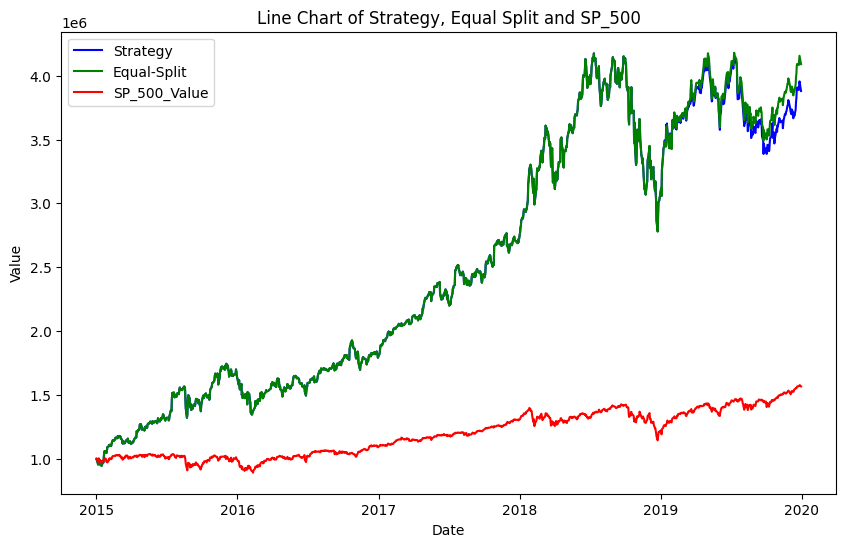

In [52]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(result_df.index, result_df['Portfolio Value'], label='Strategy', color='blue')  # Line for Column1
plt.plot(result_df.index, result_df['NS Portfolio Value'], label='Equal-Split', color='green')  # Line for Column2
plt.plot(result_df.index, result_df['SP_500_Value'], label='SP_500_Value', color='red')  # Line for Column3

# Adding title and labels
plt.title('Line Chart of Strategy, Equal Split and SP_500')
plt.xlabel('Date')
plt.ylabel('Value')

# Show legend
plt.legend()

# Display the plot
plt.show()

The max drawdown is -1395280.7171401978 or -33.42%


<Axes: >

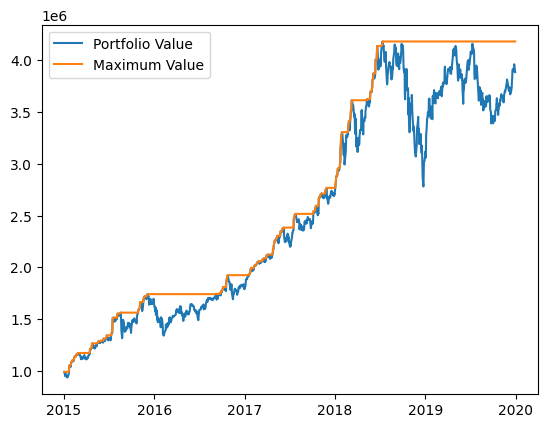

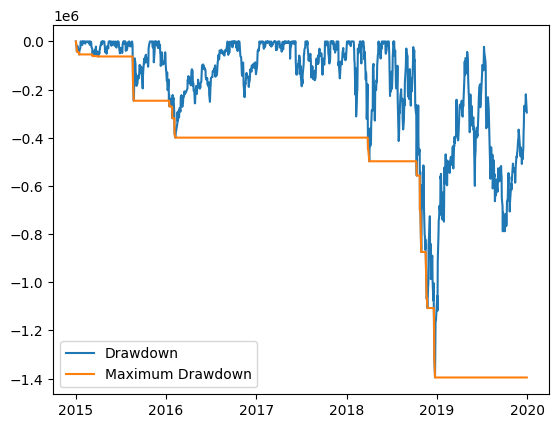

In [93]:
# Cumulative Max
result_df['Maximum Value'] = result_df['Portfolio Value'].cummax()

# Store the differences in a new colum "drawdowns"
# Note that we are calculating the drawdowns from cumsum of returns which is already in percentage.
result_df['Drawdown'] = result_df['Portfolio Value'] - result_df['Maximum Value']
result_df['Drawdown (%)'] = result_df['Drawdown']/result_df['Maximum Value']
result_df['Maximum Drawdown'] = result_df['Drawdown'].cummin()

# The maximum difference is refered as "Drawdown"
max_drawdown = result_df['Drawdown'].min()
max_drawdown_percent = result_df['Drawdown (%)'].min()
print("The max drawdown is", max_drawdown, "or", str(round(max_drawdown_percent*100,2))+"%")

#Visualise how these two look like
result_df[['Portfolio Value', 'Maximum Value']].dropna().plot()#(x='Date',y='Value (in $m)',title='Maximum Portfolio Value')
result_df[['Drawdown', 'Maximum Drawdown']].dropna().plot()#(x='Date',y='Value (in $m)',title='Maximum Drawdown')